<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#コメント" data-toc-modified-id="コメント-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>コメント</a></span></li><li><span><a href="#import" data-toc-modified-id="import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>import</a></span></li><li><span><a href="#ゲームの位置とサイズ調整" data-toc-modified-id="ゲームの位置とサイズ調整-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ゲームの位置とサイズ調整</a></span></li><li><span><a href="#DQN" data-toc-modified-id="DQN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DQN</a></span><ul class="toc-item"><li><span><a href="#import" data-toc-modified-id="import-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>import</a></span></li><li><span><a href="#GPU判定" data-toc-modified-id="GPU判定-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>GPU判定</a></span></li><li><span><a href="#パラメータ" data-toc-modified-id="パラメータ-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>パラメータ</a></span></li><li><span><a href="#関数" data-toc-modified-id="関数-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>関数</a></span></li></ul></li><li><span><a href="#スコア取得" data-toc-modified-id="スコア取得-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>スコア取得</a></span><ul class="toc-item"><li><span><a href="#スコア位置" data-toc-modified-id="スコア位置-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>スコア位置</a></span></li></ul></li><li><span><a href="#学習" data-toc-modified-id="学習-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>学習</a></span></li><li><span><a href="#モデル保存" data-toc-modified-id="モデル保存-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>モデル保存</a></span></li></ul></div>

# コメント

- 報酬を-1, 0, 1に変更

# import

In [1]:
import numpy as np
import cv2
from Tennis_observation import *
from Tennis_action import *
from window_controlle import *
import re
import sys
import copy
import os
import random
import matplotlib.pyplot as plt

In [2]:
import threading
import subprocess
import time
from win32 import win32gui

# ゲームの位置とサイズ調整

In [3]:
# window_quarter_move_resize
win_left = 953
win_top = 0
win_width = 974
win_height = 587

#window_move_resize
win_left = 1000
win_top = 0
win_width = 200
win_height = 180

In [4]:
#grab_screen
left = 1087
top = 30
width = 705
height = 545

In [5]:
#cnn
width_cnn = 84
height_cnn = 84

In [6]:
gray_frag = True

In [7]:
adjust_window_pos_size(win_left, win_top, win_width, win_height)

In [42]:
frame = grab_screen(left, top, width, height, False)

# DQN

## import 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

## GPU判定

In [10]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

## パラメータ

In [11]:
learning_rate = 0.0001
num_episodes = 500
gamma = 0.99

hidden_layer = 512

replay_mem_size = 100000
batch_size = 32

update_target_frequency = 5000

double_dqn = True

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 10000

report_interval = 10
score_to_solve = 18

clip_error = True
normalize_image = True

file2save = './model/tennis_save.pth'
save_model_frequency = 10000
resume_previous_training = False

In [12]:
position = 0
capacity = 4

In [13]:
output_list = ['state', 'action', 'new_state', 'reward', 'done', 'info']

number_of_inputs = frame.shape[0]
number_of_outputs = len(keys_to_press)
number_of_skips = 10

In [35]:
# reward
init_flag = ('0.0','0.0')
score_reward_dict = {'0.0':0, '15.0':1, '30.0':2, '40.0':3, '60.0':4, '99':99, 'nan':np.nan}

## 関数

In [15]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * math.exp(-1. * steps_done / egreedy_decay)
    
    return epsilon

In [16]:
def load_model():
    return torch.load(file2save)

In [17]:
def save_model(model):
    torch.save(model.state_dict(), file2save)

In [18]:
def preprocess_frame(frame):
    frame = frame.transpose((2,0,1))
    frame = torch.from_numpy(frame)
    frame = frame.to(device, dtype=torch.float32)
    frame = frame.unsqueeze(1)
    
    return frame

In [19]:
def plot_results():
    plt.figure(figsize=(12,5))
    plt.title('Rewards')
    plt.plot(reards_total, alpha=0.6, color='red')
    plt.savefig('Tennis_result.png')
    plt.close()

In [20]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        self.advantage1 = nn.Linear(7*7*64,hidden_layer)
        self.advantage2 = nn.Linear(hidden_layer, number_of_outputs)
        
        self.value1 = nn.Linear(7*7*64,hidden_layer)
        self.value2 = nn.Linear(hidden_layer,1)

        #self.activation = nn.Tanh()
        self.activation = nn.ReLU()
        
        
    def forward(self, x):
        
        if normalize_image:
            x = x / 255
        
        output_conv = self.conv1(x)
        output_conv = self.activation(output_conv)        
        output_conv = self.conv2(output_conv)
        output_conv = self.activation(output_conv)
        output_conv = self.conv3(output_conv)
        output_conv = self.activation(output_conv)
        
        output_conv = output_conv.view(output_conv.size(0), -1) # flatten
        
        output_advantage = self.advantage1(output_conv)
        output_advantage = self.activation(output_advantage)
        output_advantage = self.advantage2(output_advantage)
        
        output_value = self.value1(output_conv)
        output_value = self.activation(output_value)
        output_value = self.value2(output_value)
        
        output_final = output_value + output_advantage - output_advantage.mean()

        return output_final

In [22]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.number_of_frames = 0
        
        if resume_previous_training and os.path.exists(file2save):
            print("Loading previously saved model ... ")
            self.nn.load_state_dict(load_model())
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:
            
            with torch.no_grad():
                
                state = preprocess_frame(state)
                action_from_nn = self.nn(state)
                
                action = torch.max(action_from_nn,1)[1]
                action = action.item()        
        else: # random
            action = action_random()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = [ preprocess_frame(frame) for frame in state ] 
        state = torch.cat(state)
        
        new_state = [ preprocess_frame(frame) for frame in new_state ] 
        new_state = torch.cat(new_state)

        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)


        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]  
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]
        
        
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.number_of_frames % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        if self.number_of_frames % save_model_frequency == 0:
            save_model(self.nn)
        
        self.number_of_frames += 1

# スコア取得

## スコア位置

In [45]:
my_score = {'my_score':0}
enemy_score = {'enemy_score':0}
stop_flag = {'flag':False}
t1 = threading.Thread(target=get_score, args=(my_score, enemy_score, stop_flag))
t1.start()

In [46]:
message = 'stop_video'

video_stop_flag = {'flag':False}
t2 = threading.Thread(target=video_record, args=(message, video_stop_flag)) # argsで引数二つ以上じゃないとエラー出る
t2.start()

# 学習

In [48]:
memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()


reward_list = []
frames_total = 0
score_list = []

count_game = 0

active_window()
reward = 0.0

score = ('99', '99')
last_score = ('99', '99')

# 0-0になる数(ゲーム数)
for i_episode in range(num_episodes):
    

    score_list_buf = []
    reward_list_buf = []
    
    new_state = grab_screen(left, top, width, height, True)
    new_state = image_resize(new_state, width_cnn, height_cnn)
    state = new_state
    
    # 1ゲーム終わるまで継続
    while True:
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #行動決定
        action = qnet_agent.select_action(state, epsilon)
        
        #行動
        take_action(action)
        
        #新しい環境
        state = new_state
        
        new_state = grab_screen(left, top, width, height, True)
        new_state = image_resize(new_state, width_cnn, height_cnn)
        
        score = (str(my_score['my_score']), str(enemy_score['enemy_score']))
        
        #ゲームが終わったかの確認
        done = ((score != last_score) & (np.nan not in score)) & ((score == init_flag) & (len(score_list_buf) > 1))
               
        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        # 試合開始時にinit flag回避
        if (score != last_score) & ('nan' not in score) & (count_game == 0):
            count_game += 1
        
        #ポイント終了の確認
        if (score != last_score) & ('nan' not in score) & (count_game > 0):
            print(str(score))
            reward = score_reward_dict[last_score[0]] - score_reward_dict[last_score[1]]
            #reward = reward_normalize(score_difference)
            # (0,0)で報酬清算
            if (score == init_flag):
                score_list.append(score_list_buf)
                                
                if count_game > 0:
                    
                    print('reward: ' + str(reward))
                    score_list.append(score_list_buf)
                    reward_list.append(reward)
            
                break
                
            last_score = copy.copy(score)
            
    if reward >= 1:
        win_games = len(reward_list)
        print("wining after " + str(win_games) + ' games')

        #break
                

            


('0.0', '15.0')
('30.0', '30.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('15.0', '15.0')
('40.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')

KeyboardInterrupt: 

In [ ]:
('0.0', '15.0')
('30.0', '30.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('15.0', '15.0')
('40.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('30.0', '0.0')
('40.0', '0.0')
('40.0', '15.0')
('40.0', '30.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('15.0', '15.0')
('30.0', '15.0')
('40.0', '30.0')
('60.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('15.0', '0.0')
('30.0', '15.0')
('40.0', '15.0')
('0.0', '0.0')
reward: 2
wining after 29 games
('0.0', '0.0')
reward: 2
wining after 30 games
('0.0', '0.0')
reward: 2
wining after 31 games
('0.0', '0.0')
reward: 2
wining after 32 games
('0.0', '0.0')
reward: 2
wining after 33 games
('0.0', '15.0')
('0.0', '40.0')
('30.0', '0.0')
('30.0', '15.0')
('0.0', '15.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('30.0', '15.0')
('40.0', '40.0')
('0.0', '0.0')
reward: 0
('0.0', '15.0')
('0.0', '30.0')
('15.0', '30.0')
('15.0', '40.0')
('30.0', '40.0')
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '15.0')
('15.0', '15.0')
('30.0', '15.0')
('40.0', '30.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('30.0', '15.0')
('30.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '30.0')
('15.0', '30.0')
('30.0', '40.0')
('60.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('15.0', '30.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '15.0')
('15.0', '15.0')
('15.0', '30.0')
('15.0', '40.0')
('0.0', '15.0')
('15.0', '15.0')
('15.0', '30.0')

In [52]:
score_list_buf

[]

In [50]:
reward_list

[-2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 2,
 2,
 2,
 2,
 2,
 -2,
 -2,
 -2,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -2]

In [49]:
stop_flag['flag']=True
video_stop_flag['flag']=True

stop_video
stop getting score


# モデル保存

In [ ]:
save_model(qnet_agent.nn)

In [238]:
cnn = NeuralNetwork().to(device)

In [239]:
imshow(frame)

In [240]:
frame = grab_screen(left, top, width, height, gray_frag)

In [241]:
frame = image_resize(frame)

In [242]:
state = preprocess_frame(frame)

In [258]:
test = cnn(state)

In [261]:
(test[1].numpy)

<function Tensor.numpy>

In [283]:
Tensor.cpu(cnn.conv1.weight[0][0])

tensor([[ 0.0878,  0.0986, -0.1215,  0.0978,  0.1229,  0.0628,  0.1004,  0.1010],
        [-0.0140,  0.1190, -0.0269, -0.0407, -0.0323, -0.1044,  0.1086, -0.0375],
        [ 0.0280,  0.0190, -0.0576, -0.0313,  0.1178,  0.0662,  0.0254, -0.0871],
        [-0.1196,  0.0315,  0.0982, -0.0200,  0.0769, -0.0619,  0.0666, -0.0389],
        [-0.0949,  0.0067,  0.0894,  0.0438,  0.0783, -0.0769, -0.0879,  0.1173],
        [ 0.0364,  0.0657, -0.0664,  0.0204,  0.0368, -0.0279, -0.0818,  0.0533],
        [-0.0010, -0.0909, -0.0516,  0.0449,  0.0633,  0.0328,  0.0850, -0.0790],
        [ 0.0594,  0.0691,  0.0187,  0.0221,  0.0213, -0.0384,  0.0960,  0.1179]],
       grad_fn=<CopyBackwards>)

In [ ]:
Tensor.cpu(state[0][0]))

In [223]:
torch.var.

AttributeError: 'builtin_function_or_method' object has no attribute 'data'

In [181]:
a = QNet_Agent()

In [186]:
a.nn(state)

tensor([[ 0.0427, -0.0083,  0.0251,  0.0478]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [155]:
frame.T

array([[[ 90,  91,  90, ..., 141, 141, 143],
        [171, 151, 124, ..., 141, 142, 143],
        [ 18,  18,  18, ..., 143, 142, 144],
        ...,
        [109, 114, 109, ..., 143, 143, 141],
        [109, 113, 108, ..., 143, 143, 142],
        [110, 112, 107, ..., 143, 141, 143]]], dtype=uint8)

In [174]:
state = torch.cat(state[0][0][0])

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

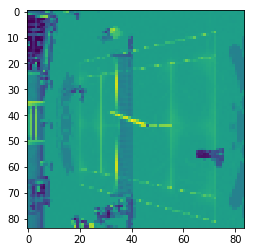

In [157]:
plt.imshow(frame.T[0])

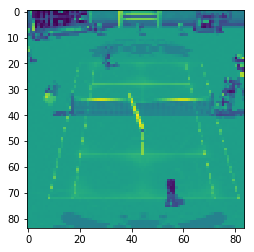

In [158]:
plt.imshow(np.array(Tensor.cpu(state[0][0])))

In [59]:
state = [ preprocess_frame(frame_) for frame_ in state ] 

TypeError: transpose(): argument 'dim0' (position 1) must be int, not tuple

In [39]:
state = preprocess_frame(state)

In [42]:
torch.cat(state[0])

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [34]:
cnn(frame)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray